<a href="https://colab.research.google.com/github/ACTP2002/EVIDENCE/blob/behavior_model/Behaviour_Model_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install --no-cache-dir -U numpy pandas scipy scikit-learn tensorflow shap matplotlib joblib h2o

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 258.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 252.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 152.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.0/35.0 MB 284.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 200.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.0/266.0 MB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 24.6 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.3
    Uninstalling scipy-1.16.3:
      Successfully uninstalled scipy-1.16.3
  Attempting uninstall: tensorboard
    Found existin

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import median_abs_deviation
import random

import h2o
from h2o.estimators import H2OExtendedIsolationForestEstimator
from h2o.estimators import H2OPrincipalComponentAnalysisEstimator

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

import shap
import joblib


In [3]:
data_path = "synthetic_data_2026-02-07.csv"

df = pd.read_csv(data_path)
df.head()

,user_id,event_time,event_type,amount,currency,channel,declared_income,account_deposit,residence_country,transaction_country,amount_in_1d,amount_out_1d,login_count_1h,failed_login_1h,new_ip_1d,geo_change_1d
0,u_123,2025-04-29T00:41:35,deposit,4340.76,GBP,api,103233,201910,AU,AU,7383.39,7514.33,0,0,False,False
1,u_066,2025-12-12T02:40:46,withdrawal,7644.75,JPY,mobile,147944,491914,BR,BR,5619.80,13616.50,0,0,True,False
2,u_323,2025-03-03T11:31:43,sell,6430.32,USD,mobile,89130,57834,CN,CN,13932.37,3767.63,4,0,False,False
3,u_279,2025-11-24T00:26:14,buy,303.06,EUR,api,26802,421080,CN,CN,3947.08,1865.10,2,0,True,False
4,u_380,2025-04-22T23:01:29,buy,1164.22,EUR,api,25900,280156,MY,MY,1918.26,1456.34,0,0,False,False


In [4]:
# convert time to proper format
df["event_time"] = pd.to_datetime(df["event_time"], errors="coerce")
# sort by user id and event time
df = df.sort_values(["user_id", "event_time"]).reset_index(drop=True)

# Normalize categorical text to ensure all lower text
cat_cols_raw = [
    "currency", "channel",
    "residence_country", "transaction_country",
    "event_type"
]

for c in cat_cols_raw:
    if c in df.columns:
        df[c] = df[c].astype(str).str.strip().str.lower()

In [5]:
df.head()

,user_id,event_time,event_type,amount,currency,channel,declared_income,account_deposit,residence_country,transaction_country,amount_in_1d,amount_out_1d,login_count_1h,failed_login_1h,new_ip_1d,geo_change_1d
0,u_000,2025-01-06 11:18:48,deposit,10254.28,gbp,mobile,102892,82668,vn,vn,12593.03,11280.03,0,0,False,False
1,u_000,2025-02-03 17:39:16,withdrawal,3584.68,usd,web,102892,82668,vn,vn,11413.28,7055.52,3,1,True,False
2,u_000,2025-02-14 13:10:20,deposit,7219.40,gbp,api,102892,82668,vn,vn,14621.12,8020.41,3,2,True,False
3,u_000,2025-02-15 17:08:36,withdrawal,9331.13,gbp,api,102892,82668,vn,vn,9792.10,9161.38,0,0,True,False
4,u_000,2025-02-18 00:55:12,deposit,5060.26,usd,mobile,102892,82668,vn,vn,15287.90,9269.69,1,2,False,False


Feature Engineering Process




1.   Rolling behaviour for each user. Purpose: To compare the behaviour within the n
window

User transaction rate:


*   More than 7 transactions => USER MEDIAN + USER MAD
*   Between 2 to 6 transactions => USER MEDIAN + GLOBAL MAD
*   1 Transaction => COHORT MEDIAN + MAD

2.   Transaction timing
3.   Financial Patterns
4.   Location Abnormality

In [6]:
# Transaction Amount Features

df["amount_abs"] = df["amount"].abs()

df["amount_to_income_ratio"] = (df["amount_abs"] / (df["declared_income"] + 1e-9))

df["deposit_to_income_ratio"] = (df["account_deposit"] / (df["declared_income"] + 1e-9))

# Net flow per day
df["net_flow_1d"] = df["amount_in_1d"] - df["amount_out_1d"]

# Transaction Gap features

grp = df.groupby("user_id", sort=False)

# Previous timestamp per group
df["prev_event_time"] = grp["event_time"].shift(1)

# Gap between consecutive transactions (in seconds)
df["gap_seconds"] = (df["event_time"] - df["prev_event_time"]).dt.total_seconds()

# Fill first-transaction gaps
df["gap_seconds"] = df["gap_seconds"].fillna(df["gap_seconds"].median())

# Log-scaled time gap
df["gap_log"] = np.log1p(df["gap_seconds"])


# Inconsistent Location

df["is_cross_border"] = (df["residence_country"] != df["transaction_country"]).astype(int)


# Access risk
df["failed_login_ratio_1h"] = (df["failed_login_1h"] / (df["login_count_1h"] + 1e-9))

df["new_ip_1d"] = df["new_ip_1d"].fillna(0)

df["geo_change_1d"] = df["geo_change_1d"].fillna(0)



In [7]:
# 1 TRANSACTION ONLY

EPS = 1e-9

# GLOBAL MEDIAN & MAD
GLOBAL_MEDIAN = df["amount_abs"].median()
GLOBAL_MAD = median_abs_deviation(df["amount_abs"], scale="normal") + EPS

# COHORT MEDIAN + MAD
cohort_cols = ["currency", "transaction_country", "channel", "event_type"]
cohort_stats = (df.groupby(cohort_cols)["amount_abs"].agg(["median", lambda x: median_abs_deviation(x, scale="normal")]).reset_index())
cohort_stats.columns = cohort_cols + ["cohort_median", "cohort_mad"]
cohort_stats["cohort_mad"] += 1e-9

df = df.merge(cohort_stats, on=cohort_cols, how="left")

In [8]:
ROLL_WINDOW = 15
ROLL_MIN = 2 # minimum transactions for rolling window else treated as single transaction

# Rolling windows (15 transactions minimum, 2 transactions at least to compute)
df["user_median_15"] = grp["amount_abs"].transform(lambda s: s.rolling(ROLL_WINDOW, min_periods=ROLL_MIN).median())

# Rolling MAD
df["user_mad_15"] = grp["amount_abs"].transform(lambda s: s.rolling(ROLL_WINDOW, min_periods=ROLL_MIN).apply(lambda x: median_abs_deviation(x, scale="normal"), raw=False))

# Fallback logic [User level => Cohort level => Global level]
df["baseline_median"] = df["user_median_15"].fillna(df["cohort_median"]).fillna(GLOBAL_MEDIAN)
df["baseline_mad"] = df["user_mad_15"].fillna(df["cohort_mad"]).fillna(GLOBAL_MAD)

# Modified z-score
df["mod_z_score"] = 0.6745 * (df["amount_abs"] - df["baseline_median"]) / (df["baseline_mad"] + EPS)
df["mod_z_score_abs"] = df["mod_z_score"].abs()

In [9]:
### EWMA (Exponentially Weighted Moving Average)
df["ewma"] = grp["amount_abs"].transform(lambda s: s.ewm(span=8, adjust=False).mean())

df["ewma_resid"] = (df["amount_abs"] - df["ewma"]).abs()


In [10]:
# Global chronological split (80,20)
cutoff = df["event_time"].quantile(0.8)

train_df = df[df["event_time"] <= cutoff].copy()
test_df = df[df["event_time"] > cutoff].copy()

print("Train:", train_df.shape, "Test:", test_df.shape)


Train: (16000, 35) Test: (4000, 35)


Extended Isolation Forest Model

Role: Detect any anomalous event or outlier

Covers:
1. Monetary Behavior: features are modified_z_score, ewma_resid, net_flow_1d
2. Temporal: features are gap_log
3. Access: features are login_count_1h, failed_login_ratio_1h, new_ip_1d
4. Geographic: is_cross_border

Features have been selected after investigating the correlation. For those highly correlated features, only one of them was maintained to improve diversity

In [11]:
# Step 1: Select the features that have high impact in determining the outlier

num_features = [
    "mod_z_score_abs",
    "ewma_resid",
    "gap_log",
    "net_flow_1d",
    "login_count_1h",
    "failed_login_ratio_1h",
    "new_ip_1d",
    "is_cross_border"
]
# isolation_forest_features = ["amount_abs", "mod_z_score_abs", "ewma_resid", "gap_log", "deposit_to_income_ratio", "amount_to_income_ratio", "amount_in_1d", "net_flow_1d", "is_cross_border"]

cat_features = [
    "currency",
    "channel",
    "event_type",
    "transaction_country"
]

# isolation_forest_features = [c for c in isolation_forest_features if c in df.columns]
num_features = [c for c in num_features if c in df.columns]
cat_features = [c for c in cat_features if c in df.columns]

In [12]:
h2o.init()

encoding = "one_hot_explicit"
eif = H2OExtendedIsolationForestEstimator(
    ntrees = 600,
    sample_size = 256,
    extension_level = len(cat_features)+len(num_features)-1,
    seed = 42,
    categorical_encoding = encoding
)

eif.train(x=cat_features+num_features, training_frame=h2o.H2OFrame(train_df))



Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "17.0.17" 2025-10-21; OpenJDK Runtime Environment (build 17.0.17+10-Ubuntu-122.04); OpenJDK 64-Bit Server VM (build 17.0.17+10-Ubuntu-122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.12/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpar12uzo7
  JVM stdout: /tmp/tmpar12uzo7/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpar12uzo7/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,06 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.9
H2O_cluster_version_age:,2 months and 18 days
H2O_cluster_name:,H2O_from_python_unknownUser_uo8k1e
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.168 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |██████████████████████████████████| (done) 100%


,number_of_trees,size_of_subsample,extension_level,seed,number_of_trained_trees,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves,min_isolated_point,max_isolated_point,mean_isolated_point,min_not_isolated_point,max_not_isolated_point,mean_not_isolated_point,min_zero_splits,max_zero_splits,mean_zero_splits
,600,256,11,42.0,600.0,8.0,8.0,8.0,11.0,96.0,42.171665,4.0,63.0,23.746666,193.0,252.0,232.25333,0.0,15.0,3.92


In [13]:
# Calculate score
eif_result = eif.predict(h2o.H2OFrame(test_df))

# Prediction score
anomaly_score = eif_result["anomaly_score"]

# Average path length  of the point in Isolation Trees from root to the leaf
mean_length = eif_result["mean_length"]

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%


In [14]:
# Convert the H2OFrame to a pandas DataFrame and extract the values as a Series/Array
test_df["iforest_score"] = anomaly_score.as_data_frame().iloc[:, 0].values
test_df["mean_length"] = mean_length.as_data_frame().iloc[:, 0].values

/usr/local/lib/python3.12/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/usr/local/lib/python3.12/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [15]:
print(test_df["iforest_score"])

53       0.592571
54       0.588364
55       0.563250
56       0.544203
57       0.495024
           ...   
19995    0.391810
19996    0.396237
19997    0.382541
19998    0.370496
19999    0.437492
Name: iforest_score, Length: 4000, dtype: float64


In [16]:
train_df[num_features].corr()

,mod_z_score_abs,ewma_resid,gap_log,net_flow_1d,login_count_1h,failed_login_ratio_1h,new_ip_1d,is_cross_border
mod_z_score_abs,1.000000,0.733976,0.000678,0.652475,0.011376,0.001255,0.006157,-0.005408
ewma_resid,0.733976,1.000000,-0.002803,0.749927,0.016469,-0.001917,0.001973,-0.004476
gap_log,0.000678,-0.002803,1.000000,0.003993,0.013787,0.012945,0.009866,0.004517
net_flow_1d,0.652475,0.749927,0.003993,1.000000,0.008485,-0.002888,0.001175,-0.002739
login_count_1h,0.011376,0.016469,0.013787,0.008485,1.000000,-0.132512,0.000690,0.000927
failed_login_ratio_1h,0.001255,-0.001917,0.012945,-0.002888,-0.132512,1.000000,-0.004893,0.008923
new_ip_1d,0.006157,0.001973,0.009866,0.001175,0.000690,-0.004893,1.000000,0.001396
is_cross_border,-0.005408,-0.004476,0.004517,-0.002739,0.000927,0.008923,0.001396,1.000000


LSTM AutoEncoder
- Detect unusual transaction patterns better than isolation forest
- Used for temporal anomalies

In [17]:
from sklearn.preprocessing import StandardScaler

# STEP 1: Identify features, create sequences, and create training and testing data

lstm_autoencoder_features = ["amount_abs", "gap_log", "amount_to_income_ratio", "net_flow_1d", "deposit_to_income_ratio", "mod_z_score_abs", "ewma_resid"]

seq_scaler = StandardScaler()
seq_scaler.fit(train_df[lstm_autoencoder_features].fillna(0))

def make_sequences(data_in, window=20):
  X = []
  idx = []
  for _, g in data_in.groupby("user_id", sort=False):
    arr = seq_scaler.transform(g[lstm_autoencoder_features].fillna(0))
    if len(arr) < window:
      continue
    for i in range (window - 1, len(arr)):
      X.append(arr[i-window+1:i+1])
      idx.append(g.index[i])
  return np.array(X), idx


X_training_lstm, idx_training_lstm = make_sequences (train_df)
X_testing_lstm, idx_testing_lstm = make_sequences (test_df)

In [18]:
# STEP 2: Train the lstm
# How LSTM works? LSTM encoder learns sequence representation => Decoder reconstructs sequence => Calculate the error in the reconstruction signals (Higher error means anomaly)

lstm_model = models.Sequential([
    layers.Input(shape=(20, len(lstm_autoencoder_features))),
    layers.LSTM(64),
    layers.RepeatVector(20),
    layers.LSTM(64, return_sequences=True),
    layers.TimeDistributed(layers.Dense(len(lstm_autoencoder_features)))
])

lstm_model.compile(optimizer="adam", loss="mse")

lstm_model.fit(
    X_training_lstm, X_training_lstm,
    epochs=40,
    batch_size=256,
    validation_split=0.1,
    callbacks=[callbacks.EarlyStopping(patience=6, restore_best_weights=True)],
    verbose=2
)

Epoch 1/40
30/30 - 10s - 339ms/step - loss: 0.9279 - val_loss: 0.7269
Epoch 2/40
30/30 - 4s - 137ms/step - loss: 0.8553 - val_loss: 0.7149
Epoch 3/40
30/30 - 3s - 110ms/step - loss: 0.8299 - val_loss: 0.6816
Epoch 4/40
30/30 - 6s - 186ms/step - loss: 0.7840 - val_loss: 0.6369
Epoch 5/40
30/30 - 4s - 137ms/step - loss: 0.7368 - val_loss: 0.5906
Epoch 6/40
30/30 - 4s - 141ms/step - loss: 0.6842 - val_loss: 0.5464
Epoch 7/40
30/30 - 7s - 237ms/step - loss: 0.6429 - val_loss: 0.5158
Epoch 8/40
30/30 - 6s - 213ms/step - loss: 0.6071 - val_loss: 0.5053
Epoch 9/40
30/30 - 3s - 107ms/step - loss: 0.6048 - val_loss: 0.4987
Epoch 10/40
30/30 - 5s - 182ms/step - loss: 0.5640 - val_loss: 0.4318
Epoch 11/40
30/30 - 3s - 111ms/step - loss: 0.5348 - val_loss: 0.4382
Epoch 12/40
30/30 - 7s - 223ms/step - loss: 0.5437 - val_loss: 0.4139
Epoch 13/40
30/30 - 6s - 206ms/step - loss: 0.6242 - val_loss: 0.4558
Epoch 14/40
30/30 - 3s - 110ms/step - loss: 0.6021 - val_loss: 0.4388
Epoch 15/40
30/30 - 3s - 113

In [39]:
y_pred_lstm = lstm_model.predict(X_testing_lstm, verbose=0)
err = np.mean((X_testing_lstm - y_pred_lstm) ** 2, axis=(1, 2))

test_df["lstm_score"] = np.nan
for i, idx in enumerate(idx_testing_lstm):
  test_df.at[idx, "lstm_score"] = err[i]

test_df["lstm_score"] = test_df["lstm_score"].fillna(test_df["lstm_score"].median())

In [40]:
print(test_df["lstm_score"])

53       0.115944
54       0.115944
55       0.115944
56       0.115944
57       0.115944
           ...   
19995    0.115944
19996    0.115944
19997    0.115944
19998    0.115944
19999    0.115944
Name: lstm_score, Length: 4000, dtype: float64


In [41]:
feature_err = np.mean((X_testing_lstm - y_pred_lstm) ** 2, axis=1)
feat_err_df = pd.DataFrame(feature_err, columns=lstm_autoencoder_features, index=idx_testing_lstm)

test_df["lstm_top_driver"] = feat_err_df.idxmax(axis=1)

In [42]:
from sklearn.preprocessing import MinMaxScaler
# from sklearn.linear_model import LogisticRegression

# meta = LogisticRegression()

detector_cols = ["mod_z_score_abs", "ewma_resid", "iforest_score", "lstm_score"]

# Calculate score
eif_train_result = eif.predict(h2o.H2OFrame(train_df))

# Number in [0, 1] explicitly defined in Equation (1) from Extended Isolation Forest paper
# or in paragraph '2 Isolation and Isolation Trees' of Isolation Forest paper
anomaly_train_score = eif_train_result["anomaly_score"]

# Average path length  of the point in Isolation Trees from root to the leaf
mean_train_length = eif_train_result["mean_length"]

train_df["iforest_score"] = anomaly_train_score.as_data_frame().iloc[:, 0].values
train_df["mean_length"] = mean_train_length.as_data_frame().iloc[:, 0].values

# train_df["iforest_score"] = -iso_pipe.decision_function(train_df)

y_pred_training_lstm = lstm_model.predict(X_training_lstm, verbose=0)
train_err = np.mean((X_training_lstm - y_pred_training_lstm) ** 2, axis=(1, 2))

train_df["lstm_score"] = np.nan
for i, idx in enumerate(idx_training_lstm):
  train_df.at[idx, "lstm_score"] = train_err[i]

train_df["lstm_score"] = train_df["lstm_score"].fillna(train_df["lstm_score"].median())


scaler = MinMaxScaler()
scaler.fit(train_df[detector_cols].fillna(0))

test_df[[c + "_n" for c in detector_cols]] = scaler.transform(test_df[detector_cols].fillna(0))

weights = {
    "mod_z_score_abs": 0.3,
    "ewma_resid": 0.15,
    "iforest_score": 0.3,
    "lstm_score": 0.25
}

test_df["final_score"] = sum(weights[c] * test_df[c+"_n"] for c in weights)
# meta.fit(train_df[detector_cols], train_labels)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%


/usr/local/lib/python3.12/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/usr/local/lib/python3.12/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [43]:
train_df["iforest_score"].describe()

count    16000.000000
mean         0.402554
std          0.049938
min          0.360745
25%          0.377830
50%          0.387620
75%          0.406982
max          0.837613
Name: iforest_score, dtype: float64

In [44]:
user_score = test_df.groupby("user_id")["final_score"].mean()
user_score

user_id
u_000    0.110717
u_001    0.029852
u_002    0.021396
u_003    0.013732
u_004    0.022663
           ...   
u_395    0.016850
u_396    0.021992
u_397    0.033573
u_398    0.013210
u_399    0.022312
Name: final_score, Length: 400, dtype: float64

In [26]:


# train_with_score = train_h2o.cbind(eif_train_result["anomaly_score"])
# train_with_score.set_names(train_with_score.names[:-1] + ["anomaly_score"])

# Get the final_score for train columns
train_df[[c + "_n" for c in detector_cols]] = scaler.transform(
    train_df[detector_cols].fillna(0)
)

train_df["final_score"] = sum(
    weights[c] * train_df[c + "_n"]
    for c in weights
)

train_h2o = h2o.H2OFrame(train_df)
for col in cat_features:
    train_h2o[col] = train_h2o[col].asfactor()

from h2o.estimators import H2OGradientBoostingEstimator

print(train_h2o.columns)

surrogate = H2OGradientBoostingEstimator(
    ntrees=400,
    max_depth=6,
    learn_rate=0.05,
    seed=42
)

surrogate.train(
    x=cat_features + num_features + detector_cols,
    y="final_score",
    training_frame=train_h2o
)




Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
['user_id', 'event_time', 'event_type', 'amount', 'currency', 'channel', 'declared_income', 'account_deposit', 'residence_country', 'transaction_country', 'amount_in_1d', 'amount_out_1d', 'login_count_1h', 'failed_login_1h', 'new_ip_1d', 'geo_change_1d', 'amount_abs', 'amount_to_income_ratio', 'deposit_to_income_ratio', 'net_flow_1d', 'prev_event_time', 'gap_seconds', 'gap_log', 'is_cross_border', 'failed_login_ratio_1h', 'cohort_median', 'cohort_mad', 'user_median_15', 'user_mad_15', 'baseline_median', 'baseline_mad', 'mod_z_score', 'mod_z_score_abs', 'ewma', 'ewma_resid', 'iforest_score', 'mean_length', 'lstm_score', 'mod_z_score_abs_n', 'ewma_resid_n', 'iforest_score_n', 'lstm_score_n', 'final_score']
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_model_python_1770903832988_2


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    400                400                         102850                 6            6            6             7             51            15.6425

ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 4.1353739285306266e-07
RMSE: 0.0006430687310490712
MAE: 0.00023074221437127562
RMSLE: 0.0005285444020519927
Mean Residual Deviance: 4.1353739285306266e-07

Scoring History: 
     timestamp            duration    number_of_trees    training_rmse          training_mae            training_deviance
---  -------------------  ----------  -----------------  ---------------------  ----------------------  ----------------------
     2026-02-12 13:58:22  0.052 sec   0.0                0.042182678087050354   0.020410601056673264    0.0017793783305957182
     2026-02-12 13:58:23  0.655 sec   1.0                0.04009662395386661    0.019396369844878792    0.0016077392524977898
     2026-02-12 13:58:23  0.865 sec   2.0                0.03811528966146885    0.018432488898019073    0.0014527753059776739
     2026-02-12 13:58:23  1.013 sec   3.0                0.03623454939506387    0.017515609791589667    0.0013129425698633235
     2026-02-12 13:58:23  1.108 sec   4.0                0.03444820008283828    0.016646113698690897    0.0011866784889472595
     2026-02-12 13:58:23  1.187 sec   5.0                0.03275149006098636    0.015820345517568057    0.0010726601012148885
     2026-02-12 13:58:24  1.279 sec   6.0                0.031140512400521358   0.015034820922621293    0.0009697315125670245
     2026-02-12 13:58:24  1.372 sec   7.0                0.029609632888692086   0.014289645524084335    0.000876730359803116
     2026-02-12 13:58:24  1.443 sec   8.0                0.028156408721758105   0.013580491589702433    0.0007927833521066959
     2026-02-12 13:58:24  1.516 sec   9.0                0.02677386733728159    0.012907994280307322    0.0007168399721943541
---  ---                  ---         ---                ---                    ---                     ---
     2026-02-12 13:58:26  3.865 sec   44.0               0.0050357734092009     0.002275901226705173    2.5359013828814855e-05
     2026-02-12 13:58:26  3.918 sec   45.0               0.004823084242711937   0.002170563223276986    2.3262141612296185e-05
     2026-02-12 13:58:26  3.979 sec   46.0               0.004625466951701222   0.002070461668568896    2.1394944521280198e-05
     2026-02-12 13:58:26  4.055 sec   47.0               0.004438319306456454   0.001975681084615644    1.9698678266064102e-05
     2026-02-12 13:58:26  4.113 sec   48.0               0.004259084016510986   0.0018846966689743568   1.813979665969935e-05
     2026-02-12 13:58:30  8.139 sec   129.0              0.0011781894085055073  0.0002948125055263517   1.3881302823145572e-06
     2026-02-12 13:58:34  12.155 sec  242.0              0.0008504896863671132  0.0002540755130321486   7.233327066168305e-07
     2026-02-12 13:58:38  16.178 sec  312.0              0.0007423641815296398  0.00024073809094988973  5.511045780181719e-07
     2026-02-12 13:58:42  20.190 sec  383.0              0.0006624605330258013  0.00023272893625835424  4.388539578168287e-07
     2026-02-12 13:58:43  21.069 sec  400.0              0.0006430687310490712  0.00023074221437127562  4.1353739285306266e-07
[54 rows x 7 columns]


Variable Importances: 
variable               relative_importance    scaled_importance    percentage
---------------------  ---------------------  -------------------  ------------
iforest_score          266.666                1                    

In [27]:
model_features = surrogate._model_json["output"]["names"]
model_features.remove("final_score")

In [45]:
# Threshold
threshold = test_df["anomaly_score"].quantile(0.95)
test_df["is_anomaly_pred"] = (
    test_df["anomaly_score"] >= threshold
).astype(int)


KeyError: 'anomaly_score'

In [28]:
shap_values = surrogate.predict_contributions(train_h2o)

# Convert H2OFrame to pandas
shap_df = shap_values.as_data_frame()

# Remove bias term
shap_df = shap_df.drop(columns=["BiasTerm"])


contributions progress: |████████████████████████████████████████████████████████| (done) 100%


/usr/local/lib/python3.12/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Surrogate R2: 0.9997675945204959


/usr/local/lib/python3.12/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


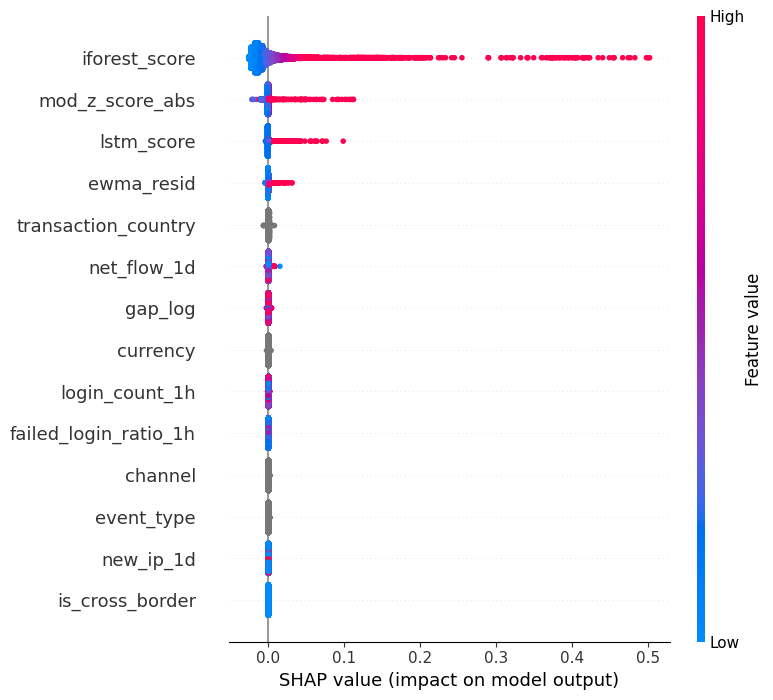

In [29]:
pred_surrogate = surrogate.predict(train_h2o).as_data_frame().values.flatten()
true_score = train_df["final_score"].values

from sklearn.metrics import r2_score

print("Surrogate R2:", r2_score(true_score, pred_surrogate))

# Feature matrix (must match training features order)
X = train_df[model_features]

# Plot
shap.summary_plot(shap_df.values, X)


In [30]:
RISK_MAPPING = {

    # Monetary Behavior
    "mod_z_score_abs": {
        "category": "Monetary Deviation",
        "template": "Transaction amount deviates from user's historical behavior."
    },
    "ewma_resid": {
        "category": "Monetary Deviation",
        "template": "Transaction differs from recent spending trend."
    },
    "net_flow_1d": {
        "category": "Liquidity Shift",
        "template": "Unusual daily net cash flow movement detected."
    },

    # Temporal Behavior
    "gap_log": {
        "category": "Temporal Anomaly",
        "template": "Transaction timing gap is inconsistent with prior activity."
    },

    # Access Risk
    "login_count_1h": {
        "category": "Access Risk",
        "template": "Abnormal login frequency observed."
    },
    "failed_login_ratio_1h": {
        "category": "Access Risk",
        "template": "Elevated failed login attempts detected."
    },
    "new_ip_1d": {
        "category": "Access Risk",
        "template": "Transaction initiated from a new IP address."
    },

    # Geographic Risk
    "is_cross_border": {
        "category": "Geolocation Risk",
        "template": "Transaction occurred outside user's residence country."
    },

    # Model Signals
    "iforest_score": {
        "category": "Structural Anomaly",
        "template": "Isolation Forest detected structural deviation."
    },
    "lstm_score": {
        "category": "Sequential Anomaly",
        "template": "Sequential behavior pattern deviates from historical norm."
    }
}


In [31]:
def generate_human_explanation(feature, value, shap_value):

    direction = "increased" if shap_value > 0 else "reduced"

    def safe_float(v):
        try:
            return float(v)
        except:
            return None

    value = safe_float(value)

    explanations = {
        "mod_z_score_abs": (
            f"Transaction amount deviates significantly from user's normal behavior "
            f"(Z-score={value:.2f}). This {direction} anomaly risk."
            if value is not None else
            f"Transaction amount deviates significantly from user's normal behavior. "
            f"This {direction} anomaly risk."
        ),

        "ewma_resid": (
            f"Recent transaction amount differs from short-term trend "
            f"(EWMA residual={value:.2f}). This {direction} anomaly risk."
            if value is not None else
            f"Recent transaction amount differs from short-term trend. "
            f"This {direction} anomaly risk."
        ),

        "iforest_score":
            f"Isolation Forest detected structural anomaly pattern. "
            f"This {direction} overall risk.",

        "lstm_score":
            f"Sequential behavior pattern deviates from historical sequence. "
            f"This {direction} anomaly likelihood.",

        "gap_log": (
            f"Transaction timing gap is unusual compared to prior activity "
            f"(gap_log={value:.2f}). This {direction} anomaly risk."
            if value is not None else
            f"Transaction timing gap is unusual compared to prior activity. "
            f"This {direction} anomaly risk."
        ),

        "net_flow_1d": (
            f"Daily net cash flow shift detected "
            f"(net_flow_1d={value:.2f}). This {direction} anomaly risk."
            if value is not None else
            f"Daily net cash flow shift detected. "
            f"This {direction} anomaly risk."
        ),

        "login_count_1h": (
            f"Abnormal login frequency in past hour "
            f"(count={int(value)}). This {direction} anomaly risk."
            if value is not None else
            f"Abnormal login frequency in past hour. "
            f"This {direction} anomaly risk."
        ),

        "failed_login_ratio_1h": (
            f"Elevated failed login attempts ratio "
            f"({value:.2f}). This {direction} anomaly risk."
            if value is not None else
            f"Elevated failed login attempts detected. "
            f"This {direction} anomaly risk."
        ),

        "new_ip_1d":
            f"New IP address detected in last 24h. "
            f"This {direction} anomaly risk.",

        "is_cross_border":
            f"Transaction occurred outside user's residence country. "
            f"This {direction} anomaly risk."
    }

    return explanations.get(
        feature,
        f"{feature} contributed to anomaly score and {direction} risk."
    )


In [32]:
def compute_shap_batch(df_input):

    if isinstance(df_input, dict):
        df_input = pd.DataFrame([df_input])

    h2o_frame = h2o.H2OFrame(df_input)

    for col in cat_features:
        if col in df_input.columns:
            h2o_frame[col] = h2o_frame[col].asfactor()

    shap_val = surrogate.predict_contributions(h2o_frame)
    shap_df = shap_val.as_data_frame().drop(columns=["BiasTerm"])

    return shap_df


In [33]:
def convert_to_risk_evidence(feature, shap_value, raw_value):

    if feature not in RISK_MAPPING:
        return None

    risk_info = RISK_MAPPING[feature]
    direction = "increased" if shap_value > 0 else "reduced"

    explanation_text = generate_human_explanation(
        feature, raw_value, shap_value
    )

    return {
        "risk_category": risk_info["category"],
        "feature": feature,
        "impact": direction,
        "contribution": float(shap_value),
        "explanation": explanation_text
    }


In [34]:
def build_readable_explanations(df_input, shap_df, top_n=5, min_abs_contribution=1e-4):

    outputs = []

    for idx in range(len(df_input)):

        shap_series = shap_df.iloc[idx]
        shap_series = shap_series[shap_series.abs() > min_abs_contribution]

        shap_series = shap_series.reindex(
            shap_series.abs().sort_values(ascending=False).index
        )

        top_features = shap_series.head(top_n)

        explanations = []

        for feature, shap_value in top_features.items():

            raw_value = (
                df_input.iloc[idx][feature]
                if feature in df_input.columns else None
            )

            evidence = convert_to_risk_evidence(
                feature, shap_value, raw_value
            )

            if evidence:
                explanations.append(evidence)

        outputs.append(explanations)

    return outputs


In [35]:
def aggregate_by_category(evidence_list):

    category_summary = {}

    for item in evidence_list:

        category = item["risk_category"]
        contribution = item["contribution"]

        if category not in category_summary:
            category_summary[category] = {
                "total_contribution": 0.0,
                "net_direction_score": 0.0
            }

        category_summary[category]["total_contribution"] += abs(contribution)
        category_summary[category]["net_direction_score"] += contribution

    output = []

    for category, values in category_summary.items():

        direction = (
            "increased"
            if values["net_direction_score"] > 0
            else "reduced"
        )

        output.append({
            "risk_category": category,
            "impact": direction,
            "strength": round(values["total_contribution"], 6)
        })

    output = sorted(output, key=lambda x: x["strength"], reverse=True)

    return output


In [36]:
def build_output(df_input, top_n=5):

    if isinstance(df_input, dict):
        df_input = pd.DataFrame([df_input])

    shap_df = compute_shap_batch(df_input)

    explanations_list = build_readable_explanations(
        df_input, shap_df, top_n=top_n
    )

    results = []

    for idx in range(len(df_input)):

        evidence = explanations_list[idx]
        category_summary = aggregate_by_category(evidence)

        results.append({
            "anomaly_score": float(df_input.iloc[idx]["final_score"]),
            "is_anomaly": int(df_input.iloc[idx]["is_anomaly"]),
            "top_drivers": evidence,
            "risk_summary": category_summary
        })

    if len(results) == 1:
        return results[0]

    return results


In [37]:
test_df.loc[test_df['user_id'] == 'u_090']

,user_id,event_time,event_type,amount,currency,channel,declared_income,account_deposit,residence_country,transaction_country,...,ewma,ewma_resid,iforest_score,mean_length,lstm_score,mod_z_score_abs_n,ewma_resid_n,iforest_score_n,lstm_score_n,final_score
4467,u_090,2025-10-22 08:35:26,buy,9884.72,usd,mobile,118214,304518,jp,jp,...,5783.237952,4101.482048,0.586139,7.895505,0.115944,0.004509,0.008271,0.472654,0.00282,0.145095
4468,u_090,2025-10-24 14:42:18,sell,2563.82,jpy,web,118214,304518,jp,jp,...,5067.811740,2503.991740,0.406194,13.315752,0.115944,0.003157,0.005049,0.095306,0.00282,0.031001
4469,u_090,2025-10-26 05:15:52,withdrawal,5771.78,eur,mobile,118214,304518,jp,jp,...,5224.249131,547.530869,0.368976,14.736078,0.115944,0.000000,0.001104,0.017261,0.00282,0.006049
4470,u_090,2025-11-02 21:34:34,buy,1856.44,usd,api,118214,304518,jp,jp,...,4475.847102,2619.407102,0.399829,13.549186,0.115944,0.003783,0.005282,0.081959,0.00282,0.027220
4471,u_090,2025-11-11 17:01:11,deposit,6717.74,jpy,web,118214,304518,jp,jp,...,4974.045524,1743.694476,0.377553,14.396466,0.115944,0.000929,0.003516,0.035246,0.00282,0.012085
4472,u_090,2025-11-13 15:16:15,deposit,5803.44,usd,mobile,118214,304518,jp,jp,...,5158.355407,645.084593,0.380794,14.270130,0.115944,0.000059,0.001301,0.042042,0.00282,0.013531
4473,u_090,2025-11-15 12:00:45,sell,7811.00,jpy,api,118214,304518,jp,jp,...,5747.831984,2063.168016,0.425259,12.637799,0.115944,0.002003,0.004160,0.135288,0.00282,0.042516
4474,u_090,2025-11-17 14:53:58,deposit,230572.92,jpy,mobile,118214,304518,jp,jp,...,55708.962654,174863.957346,0.802394,3.253916,0.115944,0.206530,0.352610,0.926145,0.00282,0.393399
4475,u_090,2025-11-20 13:54:06,deposit,6168.99,usd,api,118214,304518,jp,jp,...,44700.079842,38531.089842,0.605580,7.413219,0.115944,0.000337,0.077697,0.513423,0.00282,0.166488
4476,u_090,2025-11-22 09:49:34,sell,3883.12,jpy,web,118214,304518,jp,jp,...,35629.644321,31746.524321,0.604058,7.450429,0.115944,0.001769,0.064016,0.510230,0.00282,0.163907


In [38]:
build_output((test_df.loc[test_df['user_id'] == 'u_090'])[0:1])
# build_output((test_df.head(10)))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
contributions progress: |████████████████████████████████████████████████████████| (done) 100%


/usr/local/lib/python3.12/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


KeyError: 'is_anomaly'

In [102]:
user_anom = (
    test_df.groupby("user_id")["is_anomaly"]
    .sum()
    .sort_values(ascending=False)
)

print("Top 10 users by anomaly count:")
print(user_anom.head(10))


Top 10 users by anomaly count:
user_id
u_090    11
u_186    10
u_182     9
u_157     9
u_029     9
u_014     6
u_000     6
u_192     6
u_313     6
u_385     6
Name: is_anomaly, dtype: int64


In [103]:
n_users = user_anom.shape[0]
top_k = max(1, int(0.05 * n_users))

share_top5 = user_anom.head(top_k).sum() / (user_anom.sum() + 1e-9)

print(f"Top 5% users contribute: {share_top5:.2%} of all anomalies")


Top 5% users contribute: 60.50% of all anomalies


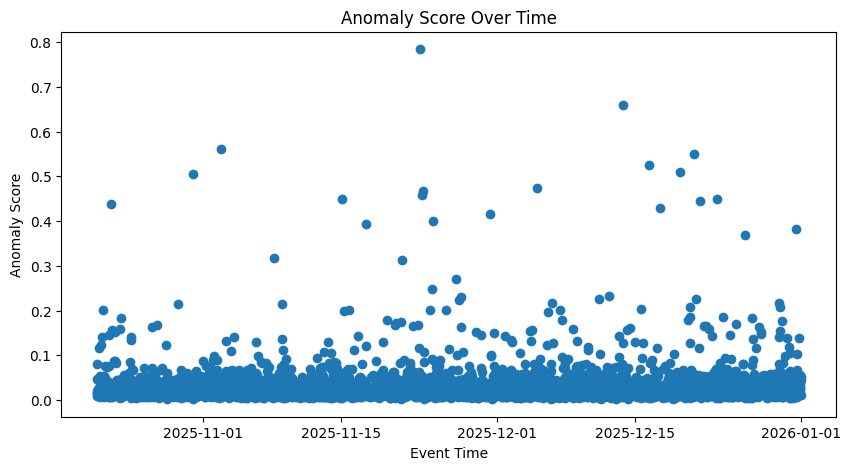

In [104]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.scatter(
    test_df["event_time"],
    test_df["final_score"]
)
plt.xlabel("Event Time")
plt.ylabel("Anomaly Score")
plt.title("Anomaly Score Over Time")
plt.show()
